In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
#from causalml.inference.tree import CausalRandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from econml.dml import CausalForestDML


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
data_hedonic = pd.read_csv('/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Total_Features_hedonic.csv')
data_utilitarian = pd.read_csv('/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Total_Features_utilitarian.csv')

In [3]:
# FIltering Data 

data_hedonic = data_hedonic[data_hedonic['product_type'] == "Chocolate"]
data_utilitarian = data_utilitarian[data_utilitarian['product_type'] == "Gaming Mouse"]

In [4]:
# Coding for hedonic and utilitarian Prodcut choice
data_hedonic ["product"] = 1
data_utilitarian ["product"] = 0

In [5]:
# Filtering data where helpful votes are not 0
data_hedonic = data_hedonic[data_hedonic['helpful_vote'] != 0]
data_utilitarian = data_utilitarian[data_utilitarian['helpful_vote'] != 0]


In [6]:
# Assuming you have two separate dataframes: data_hedonic and data_utilitarian
# Merge the dataframes into one
combined_df = pd.concat([data_hedonic, data_utilitarian], ignore_index=True)

In [9]:
# Definie features: 

# set variables 
treatment = 'product'
outcome = 'helpful_ratio'
covariates = [
    'rating', 'rating_number', 'sentiment', 'price', 'noun_count', 'adj_count', 
    'adv_count', 'word_count', 'sentence_count', 'avg_words_per_sentence', 
    'title_length', 'review_extremity', 'elapsed_time_days', 
    'image', 'year', 'month', 'day', 'hour'
]

In [10]:
# split data into train and test sets 
train, test = train_test_split(combined_df, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome]
T = train[treatment]
X = train[covariates]
W = None
X_test = test[covariates]

In [11]:
# Convert Y and T to numeric types
Y = pd.to_numeric(Y, errors='coerce')
T = pd.to_numeric(T, errors='coerce')

# Check the data types after conversion
print("Data type of Y after conversion:", Y.dtype)
print("Data type of T after conversion:", T.dtype)


Data type of Y after conversion: float64
Data type of T after conversion: int64


In [21]:

from econml.dml import CausalForestDML
from sklearn.linear_model import MultiTaskLassoCV, LassoCV

# set parameters for causal forest 
causal_forest = CausalForestDML(criterion='het', 
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(),
                                )

# fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=W)
# estimate the CATE with the test set 
causal_forest.const_marginal_ate(X_test)

-0.2416019832173133

If you've encoded your treatments (hedonic and utilitarian products) as 1 and 0, respectively, then a CATE value of -0.20365888486819608 suggests the following interpretation:

Hedonic Products (Treatment = 1): The negative CATE value indicates that, on average, choosing hedonic products (treatment = 1) leads to a decrease in the outcome variable ('helpful_ratio') compared to not choosing hedonic products.
Utilitarian Products (Treatment = 0): Conversely, not choosing hedonic products (treatment = 0, or by implication, choosing utilitarian products) is associated with a higher value of the outcome variable ('helpful_ratio') compared to choosing hedonic products.
In other words, this suggests that, on average, the 'helpful_ratio' tends to be higher when users choose utilitarian products compared to when they choose hedonic products. This interpretation assumes that the causal relationship between the treatment and outcome is accurately captured by the CATE estimate and that confounding factors have been appropriately controlled for in the analysis.

100%|===================| 825/827 [03:23<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


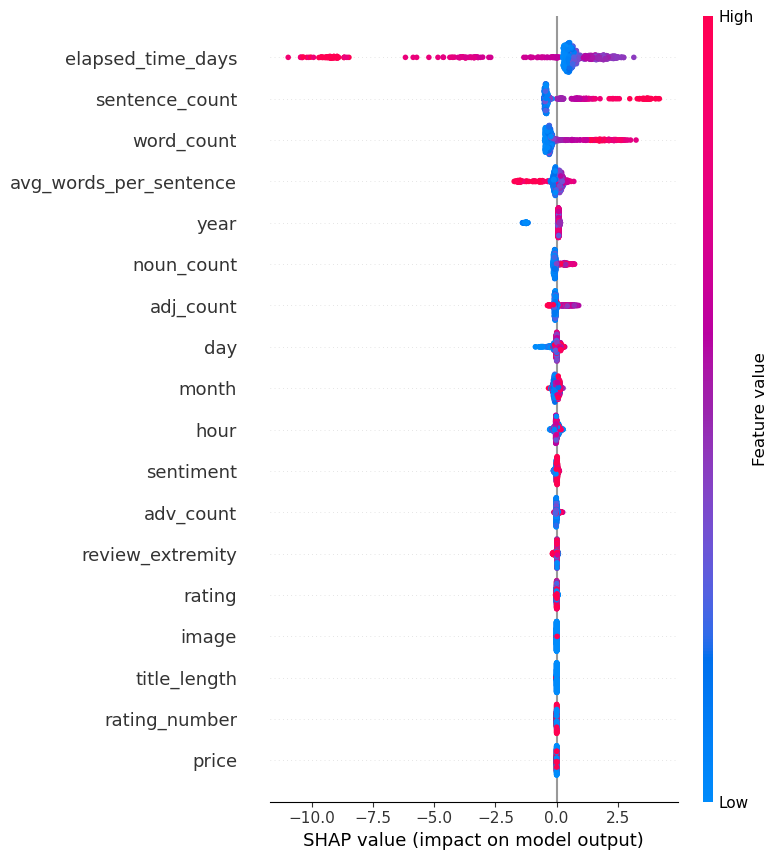

In [22]:
import shap

# Calculate SHAP values for your model (causal forest)
shap_values = causal_forest.shap_values(X)

# Extract the SHAP values for the specific treatment ('product')
shap_values_product = shap_values['helpful_ratio']['product']

# Get the feature names
feature_names = X.columns.tolist()

# Plot the SHAP values using a beeswarm plot
shap.summary_plot(shap_values_product, features=X, feature_names=feature_names)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9928143539266197e-05, tolerance: 1.8996985260958264e-05
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1980304569624298e-05, tolerance: 1.8996985260958264e-05
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2263076389500425e-05, tolerance: 1.8996985260958264e-05
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2362885778948183e-05, tolerance: 1.8996985260958264e-05
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2313412515628794e-05, tolerance: 1.8996985260958264e-05
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2143285780179545e-05, tolerance: 1.8996985260958264e-05
Objective did not converge. You might want to increase the number of iterations. Duality

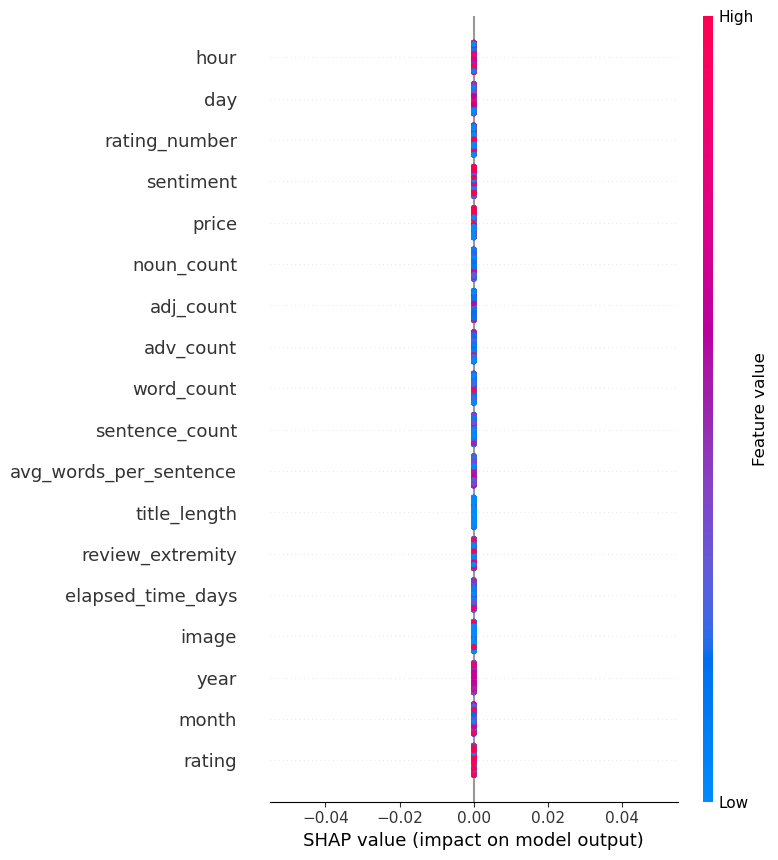

In [19]:
import shap
from econml.dml import CausalForestDML

# Create a new instance of CausalForestDML with default parameters
causal_forest_default = CausalForestDML()

# Fit the causal forest model with default parameters
causal_forest_default.fit(Y, T, X=X, W=W)

# Calculate SHAP values for your model (causal forest)
shap_values = causal_forest_default.shap_values(X)

# Extract the SHAP values for the specific treatment ('product')
shap_values_product = shap_values['helpful_ratio']['product']

# Get the feature names
feature_names = X.columns.tolist()

# Plot the SHAP values using a beeswarm plot
shap.summary_plot(shap_values_product, features=X, feature_names=feature_names)


"The feature that exhibited the most substantial influence on online review helpfulness was the elapsed time since posting, followed closely by the sentence count and word count in the review text. Notably, the impact of these features was particularly pronounced when considering hedonic products. This finding suggests that the temporal aspect of reviews, as well as their length and complexity, play a crucial role in determining their perceived helpfulness, especially in the context of hedonic products.

